# EEG analysis

This notebook applies several metrics after filtering to discriminate between conditions.

The following functions can be used to characterize rhythms in time series and synchrony between them.

References:
- Stam, Nolte, Daffertshofer (2007) Hum Brain Mapp, 28: 1178-1193
- Vinck, Oostenveld, van Wingerden, , Pennartz (2011) Neuroimage, 55: 1548-1565

In [87]:
import scipy.io as sio
import numpy as np
import scipy.signal as spsg
import scipy.stats as stt
import matplotlib.pyplot as plt


###########
# filtering

# band-pass filtering
def bandpass_filter(ts, low_f_nyq, high_f_nyq, filt_order=3, axis=-1):
    b,a = spsg.iirfilter(filt_order, [low_f_nyq,high_f_nyq], btype='bandpass', ftype='butter')
    return spsg.filtfilt(b, a, ts, axis=axis)
    
    
#######################
# channel-wise measures

def power_envelope(ts, axis=-1):
    # envelope of the Hilbert transform
    return np.abs(spsg.hilbert(ts, axis=axis)).mean(axis=axis)


################################
# connectivity pairwise measures

def magnitude_squared_coherence(ts):
    N = ts.shape[0]
    T = ts.shape[1]
    # coherence matrix computed using the Hilbert transform
    ts_h = spsg.hilbert(ts,axis=1)
    ts_coh_t = np.zeros([N,N,T], dtype=np.complex)
    for i_t in range(T):
        ts_coh_t[:,:,i_t] = np.outer(ts_h[:,i_t], np.conjugate(ts_h[:,i_t]))
    ts_coh = np.abs(ts_coh_t.mean(axis=2))**2
    ts_coh /= np.outer(ts_coh.diagonal(),ts_coh.diagonal())
    return ts_coh

def phase_lag_index(ts):
    N = ts.shape[0]
    T = ts.shape[1]
    # phase lag index computed using the Hilbert transform, quantifying the average phase difference between nodes
    ts_phase = np.angle(spsg.hilbert(ts,axis=1))
    ts_pli = np.zeros([N,N,T])
    for i_t in range(T):
        ts_pli[:,:,i_t] = np.sign(np.sin(np.outer(ts_phase[:,i_t],np.ones(N)) - np.outer(np.ones(N),ts_phase[:,i_t])))
    return np.abs(ts_pli.mean(axis=2))

def weighted_phase_lag_index(ts):
    N = ts.shape[0]
    T = ts.shape[1]
    # weighted phase lag index computed using the Hilbert transform
    ts_phase = np.angle(spsg.hilbert(ts,axis=1))
    ts_wpli = np.zeros([N,N,T])
    for i_t in range(T):
        ts_wpli[:,:,i_t] = np.sin(np.outer(ts_phase[:,i_t],np.ones(N)) - np.outer(np.ones(N),ts_phase[:,i_t]))
    return np.abs(ts_wpli.mean(axis=2)) / np.abs(ts_wpli).mean(axis=2)

## Hilbert transform

It transforms a real signal (or time series) into a complex signal, with a radius $\rho(t)$ and an phase $\phi(t)$.
$$ x(t) \rightarrow \rho(t) e^{i \phi(t)} .$$
To give meaningful results, especially for phases, the oscillation in the signal must be sufficiently strong, so it is usually applied after narrow-bandpass filtering.

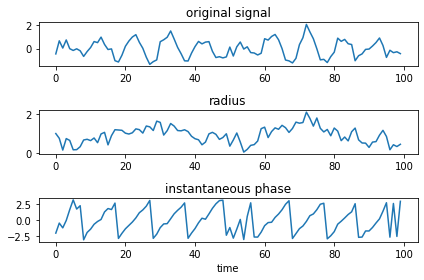

In [88]:
# example noisy signal
x = np.sin(2*np.pi*(0.1 * np.arange(100))) * (0.3+np.sin(2*np.pi*(0.01 * np.arange(100)))**2)
x += np.random.randn(100) * 0.3 # CHANGE THE NOISE SCALING HERE

# plot time series
plt.figure()
plt.subplot(311)
plt.plot(x)
plt.title('original signal')
plt.subplot(312)
plt.plot(np.abs(spsg.hilbert(x)))
plt.title('radius')
plt.subplot(313)
plt.plot(np.angle(spsg.hilbert(x)))
plt.xlabel('time')
plt.title('instantaneous phase')
plt.tight_layout()

plt.show()

### Noiseless oscillations

Firstly, we test the measures with some purely oscillatory signals.

TO DO: Change the phase phi_y and compare the effect on the metrics. Then do the same with f_z.

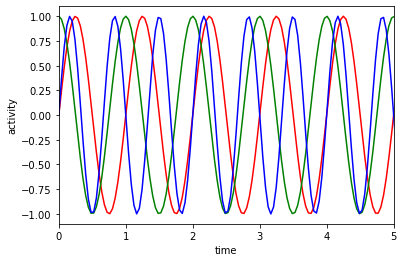

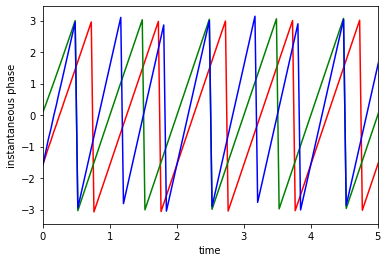

In [89]:
# time span
t = np.linspace(0,20,500)

# frequencies
f_x = 1.
f_y = 1.
f_z = 1.5 # CHANGE THE FREQUENCY TO 2. and 1.

# phases
phi_x = 0.
phi_y = 0.25 # CHANGE THE PHASE FROM 0.5 (90 deg phase lag) TO 0.5 (anticorrelated, 180 deg) and 0. (correlated)
phi_z = 0.

x = np.sin(2*np.pi*(f_x * t + phi_x))
y = np.sin(2*np.pi*(f_y * t + phi_y))
z = np.sin(2*np.pi*(f_z * t + phi_z))

# plot time series
plt.figure()
plt.plot(t, x, 'r')
plt.plot(t, y, 'g')
plt.plot(t, z, 'b')
plt.axis(xmin=0, xmax=5)
plt.xlabel('time')
plt.ylabel('activity')

plt.figure()
plt.plot(t, np.angle(spsg.hilbert(x)), 'r')
plt.plot(t, np.angle(spsg.hilbert(y)), 'g')
plt.plot(t, np.angle(spsg.hilbert(z)), 'b')
plt.axis(xmin=0, xmax=5)
plt.xlabel('time')
plt.ylabel('instantaneous phase')

plt.show()

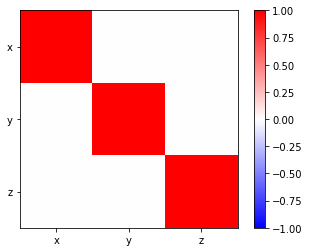

In [90]:
# Pearson correlation

plt.figure()
plt.imshow(np.corrcoef(np.vstack((x,y,z))), vmin=-1, vmax=1, cmap='bwr')
plt.colorbar()
plt.xticks(range(3), ['x','y','z'])
plt.yticks(range(3), ['x','y','z'])

plt.show()

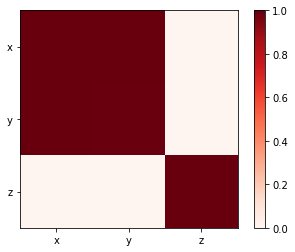

In [91]:
# magnitude squared coherence

plt.figure()
plt.imshow(magnitude_squared_coherence(np.vstack((x,y,z))), vmin=0, vmax=1, cmap='Reds')
plt.colorbar()
plt.xticks(range(3), ['x','y','z'])
plt.yticks(range(3), ['x','y','z'])

plt.show()

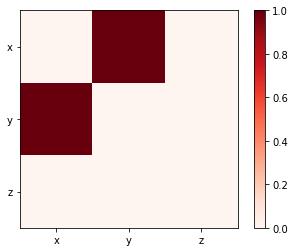

[[0.    1.    0.002]
 [1.    0.    0.   ]
 [0.002 0.    0.   ]]


In [92]:
# phase lag index

plt.figure()
plt.imshow(phase_lag_index(np.vstack((x,y,z))), vmin=0, vmax=1, cmap='Reds')
plt.colorbar()
plt.xticks(range(3), ['x','y','z'])
plt.yticks(range(3), ['x','y','z'])

plt.show()

print(phase_lag_index(np.vstack((x,y,z))))

/Users/gilsonmatthieu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


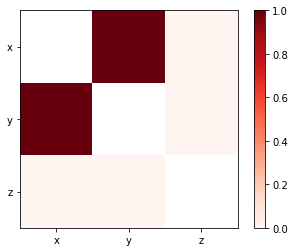

In [93]:
# weighted phase lag index

plt.figure()
plt.imshow(weighted_phase_lag_index(np.vstack((x,y,z))), vmin=0, vmax=1, cmap='Reds')
plt.colorbar()
plt.xticks(range(3), ['x','y','z'])
plt.yticks(range(3), ['x','y','z'])

plt.show()

### Noisy oscillations

Same as above with the same synthetic signals on which we add noise.

TO DO: Check the robustness of the metrics with respect to the level of noise sigma.

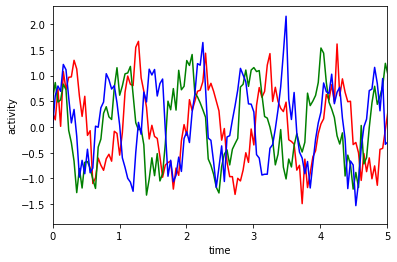

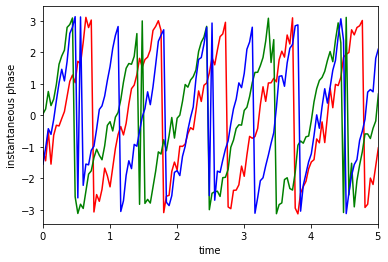

In [94]:
# time span
t = np.linspace(0,20,500)

# frequencies
f_x = 1.
f_y = 1.
f_z = 1.5

# phases
phi_x = 0.
phi_y = 0.25
phi_z = 0.

# noise level
sigma = 0.3 # CHANGE THIS TO 0.8

x = np.sin(2*np.pi*(f_x * t + phi_x)) + np.random.randn(t.size) * sigma
y = np.sin(2*np.pi*(f_y * t + phi_y)) + np.random.randn(t.size) * sigma
z = np.sin(2*np.pi*(f_z * t + phi_z)) + np.random.randn(t.size) * sigma

# plot time series
plt.figure()
plt.plot(t, x, 'r')
plt.plot(t, y, 'g')
plt.plot(t, z, 'b')
plt.axis(xmin=0, xmax=5)
plt.xlabel('time')
plt.ylabel('activity')

plt.figure()
plt.plot(t, np.angle(spsg.hilbert(x)), 'r')
plt.plot(t, np.angle(spsg.hilbert(y)), 'g')
plt.plot(t, np.angle(spsg.hilbert(z)), 'b')
plt.axis(xmin=0, xmax=5)
plt.xlabel('time')
plt.ylabel('instantaneous phase')

plt.show()

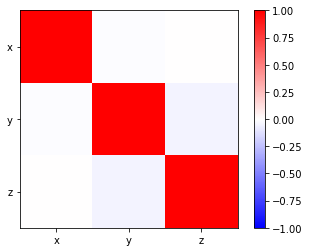

In [95]:
# Pearson correlation

plt.figure()
plt.imshow(np.corrcoef(np.vstack((x,y,z))), vmin=-1, vmax=1, cmap='bwr')
plt.colorbar()
plt.xticks(range(3), ['x','y','z'])
plt.yticks(range(3), ['x','y','z'])

plt.show()

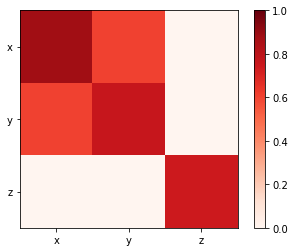

In [96]:
# magnitude squared coherence

plt.figure()
plt.imshow(magnitude_squared_coherence(np.vstack((x,y,z))), vmin=0, vmax=1, cmap='Reds')
plt.colorbar()
plt.xticks(range(3), ['x','y','z'])
plt.yticks(range(3), ['x','y','z'])

plt.show()

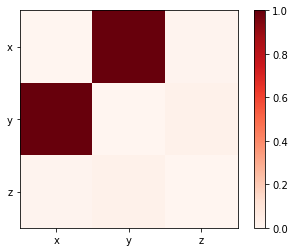

In [97]:
# phase lag index

plt.figure()
plt.imshow(phase_lag_index(np.vstack((x,y,z))), vmin=0, vmax=1, cmap='Reds')
plt.colorbar()
plt.xticks(range(3), ['x','y','z'])
plt.yticks(range(3), ['x','y','z'])

plt.show()

/Users/gilsonmatthieu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


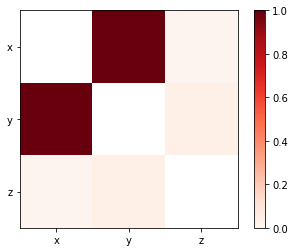

In [98]:
# weighted phase lag index

plt.figure()
plt.imshow(weighted_phase_lag_index(np.vstack((x,y,z))), vmin=0, vmax=1, cmap='Reds')
plt.colorbar()
plt.xticks(range(3), ['x','y','z'])
plt.yticks(range(3), ['x','y','z'])

plt.show()

### Superposed oscillations

Now we test the measures with signals mixing several oscillations and noise.

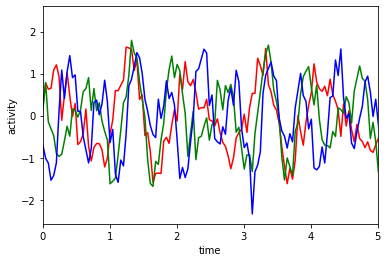

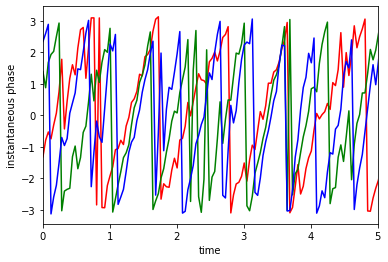

In [99]:
# time span
t = np.linspace(0,20,500)

# frequencies
f1 = 1.
f2 = 1.5
f3 = 2.

# phases
phi_x = 0.
phi_y = 0.25
phi_z = 0.5
d_phi = 0.25

# noise level
sigma = 0.3

x = np.sin(2*np.pi*(f1 * t + phi_x)) + 0.5 * np.sin(2*np.pi*(f2 * t + phi_x + d_phi)) + np.random.randn(t.size) * sigma
y = np.sin(2*np.pi*(f2 * t + phi_y)) + 0.5 * np.sin(2*np.pi*(f3 * t + phi_y + d_phi)) + np.random.randn(t.size) * sigma
z = np.sin(2*np.pi*(f3 * t + phi_z)) + 0.5 * np.sin(2*np.pi*(f1 * t + phi_z + d_phi)) + np.random.randn(t.size) * sigma

# plot time series
plt.figure()
plt.plot(t, x, 'r')
plt.plot(t, y, 'g')
plt.plot(t, z, 'b')
plt.axis(xmin=0, xmax=5)
plt.xlabel('time')
plt.ylabel('activity')

plt.figure()
plt.plot(t, np.angle(spsg.hilbert(x)), 'r')
plt.plot(t, np.angle(spsg.hilbert(y)), 'g')
plt.plot(t, np.angle(spsg.hilbert(z)), 'b')
plt.axis(xmin=0, xmax=5)
plt.xlabel('time')
plt.ylabel('instantaneous phase')

plt.show()

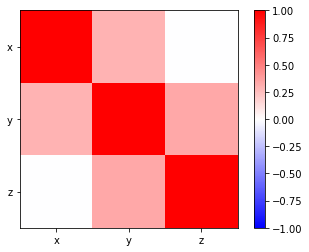

In [100]:
# Pearson correlation

plt.figure()
plt.imshow(np.corrcoef(np.vstack((x,y,z))), vmin=-1, vmax=1, cmap='bwr')
plt.colorbar()
plt.xticks(range(3), ['x','y','z'])
plt.yticks(range(3), ['x','y','z'])

plt.show()

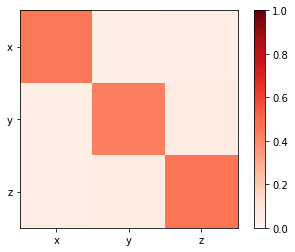

In [101]:
# magnitude squared coherence

plt.figure()
plt.imshow(magnitude_squared_coherence(np.vstack((x,y,z))), vmin=0, vmax=1, cmap='Reds')
plt.colorbar()
plt.xticks(range(3), ['x','y','z'])
plt.yticks(range(3), ['x','y','z'])

plt.show()

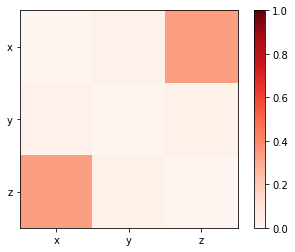

In [102]:
# phase lag index

plt.figure()
plt.imshow(phase_lag_index(np.vstack((x,y,z))), vmin=0, vmax=1, cmap='Reds')
plt.colorbar()
plt.xticks(range(3), ['x','y','z'])
plt.yticks(range(3), ['x','y','z'])

plt.show()

/Users/gilsonmatthieu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


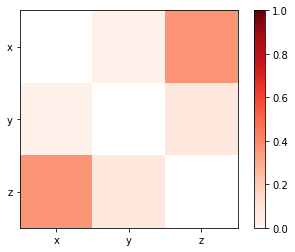

In [103]:
# weighted phase lag index

plt.figure()
plt.imshow(weighted_phase_lag_index(np.vstack((x,y,z))), vmin=0, vmax=1, cmap='Reds')
plt.colorbar()
plt.xticks(range(3), ['x','y','z'])
plt.yticks(range(3), ['x','y','z'])

plt.show()

## EEG data

Now we look at real data.

In [104]:
# load the EEG time series
trials_tmp_L = sio.loadmat('../../datasets/EEG/trials_ALH.mat')['trials']
trials_tmp_R = sio.loadmat('../../datasets/EEG/trials_ARH.mat')['trials']
t_stim = 500 # stimulus at 1000, interesting window for attention from 750 to 1000
n_left = 140 # number of trials for left attention
n_right = 115 # number of trials for left attention
n_trials = n_left + n_right # all trials
trial_info = np.zeros(n_trials, dtype=np.int)
trial_info[n_left:] = 1 # 0=left, 1=right
trial_info = trial_info.reshape([-1,1])


# EEG channel properties    
N = 58 # number of channels (electrodes)

T = 1001 # number of time points for each trial
sampling_rate = 500. # sampling frequency for EEG signal
nyquist_freq = sampling_rate / 2. # Nyquist frequency
T_w = 250 # number of time points per window
n_w = 1 # number of windows (starting with a window before the stimulus)

t_ref = t_stim - T_w # start window at 500=1s before stim, each window with width=0.5s

n_rep = 100  # number of splits for classification

trials = np.zeros([n_trials,N,T]) # channel activity for all trials
trial_labels = np.zeros([n_trials]) # result of trial
for i_trial in range(n_left):
    # get channel activity
    trials[i_trial,:,:] = trials_tmp_L[0,i_trial]
for i_trial in range(n_right):
    # get channel activity
    trials[i_trial+n_left,:,:] = trials_tmp_R[0,i_trial]
for i_trial in range(n_trials):
    # center the time series
    trials[i_trial,:,:] -= np.outer(trials[i_trial,:,:].mean(1),np.ones([T]))
    # get hit/miss info
    trial_labels[i_trial] = trial_info[i_trial,0]

del trials_tmp_L
del trials_tmp_R
del trial_info

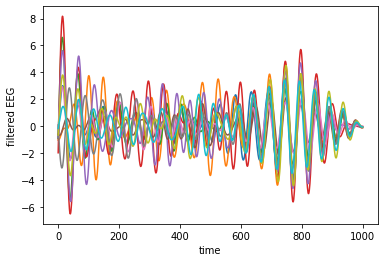

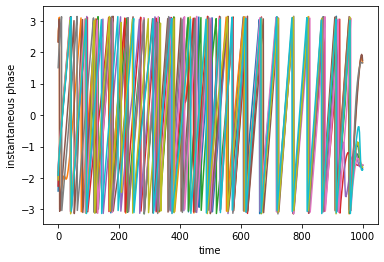

In [105]:
filter_type = 'alpha'

# band-pass filtering for alpha, beta, gamma
if filter_type=='theta':
    low_f = 4. / nyquist_freq
    high_f = 7. / nyquist_freq
elif filter_type=='alpha':
    low_f = 8. / nyquist_freq
    high_f = 12. / nyquist_freq
elif filter_type=='beta':    
    low_f = 15. / nyquist_freq
    high_f = 30. / nyquist_freq
elif filter_type=='gamma':
    low_f = 40. / nyquist_freq
    high_f = 80. / nyquist_freq
else:
    raise NameError('unknown filter')
    
# filtering
filtered_trials = bandpass_filter(trials, low_f, high_f)

# example plot for 10 channels  a single trials

plt.figure()
plt.plot(range(T),filtered_trials[0,:10,:].T)
plt.xlabel('time')
plt.ylabel('filtered EEG')

plt.figure()
plt.plot(range(T),np.angle(spsg.hilbert(filtered_trials[0,:10,:])).T)
plt.xlabel('time')
plt.ylabel('instantaneous phase')

plt.show()

In [110]:
# apply the metrics to a pair of channel (TRY OTHER PAIRS)
i = 52
j = 54

pow = np.zeros([n_trials,2])
corr = np.zeros([n_trials])
coh = np.zeros([n_trials])
pli = np.zeros([n_trials])
wpli = np.zeros([n_trials])

for i_trial in range(n_trials):
    pow[i_trial,:] = power_envelope(filtered_trials[i_trial,[i,j],:])
    corr[i_trial] = np.corrcoef(filtered_trials[i_trial,[i,j],:])[0,1]
    coh[i_trial] = magnitude_squared_coherence(filtered_trials[i_trial,[i,j],:])[0,1]
    pli[i_trial] = phase_lag_index(filtered_trials[i_trial,[i,j],:])[0,1]
    wpli[i_trial] = weighted_phase_lag_index(filtered_trials[i_trial,[i,j],:])[0,1]

# statistical testing between the two conditions
print('pow i:', stt.ttest_ind(pow[:n_left,0], pow[n_left:,0], equal_var=False))
print('pow j:', stt.ttest_ind(pow[:n_left,1], pow[n_left:,1], equal_var=False))
print('corr:', stt.ttest_ind(corr[:n_left], corr[n_left:], equal_var=False))
print('coh:', stt.ttest_ind(coh[:n_left], coh[n_left:], equal_var=False))
print('pli:', stt.ttest_ind(pli[:n_left], pli[n_left:], equal_var=False))
print('wpli:', stt.ttest_ind(wpli[:n_left], wpli[n_left:], equal_var=False))


/Users/gilsonmatthieu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


pow i: Ttest_indResult(statistic=-3.9828170592762118, pvalue=9.613024635172193e-05)
pow j: Ttest_indResult(statistic=3.1814989045028255, pvalue=0.0016579015714953205)
corr: Ttest_indResult(statistic=-1.8770263294812595, pvalue=0.06176619758443259)
coh: Ttest_indResult(statistic=0.007734564204151953, pvalue=0.9938356747469004)
pli: Ttest_indResult(statistic=-1.5904186571444432, pvalue=0.11307647340285207)
wpli: Ttest_indResult(statistic=-0.6004699365950381, pvalue=0.5487989223024086)


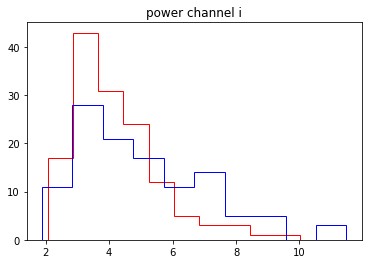

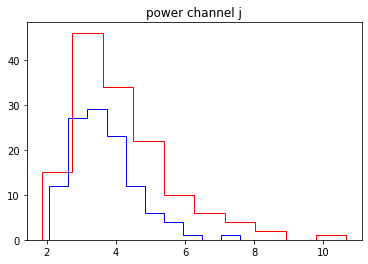

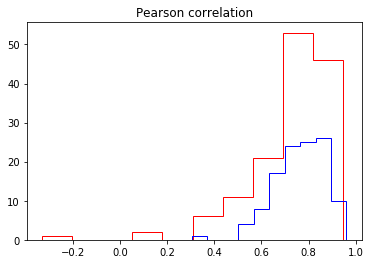

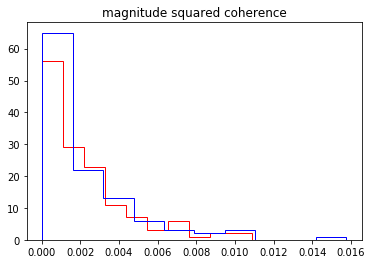

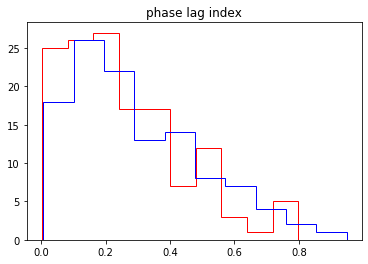

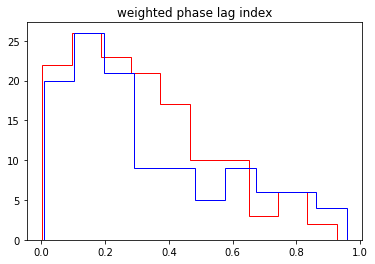

In [107]:
# plot the distributions (left in red and right in blue)

plt.figure()
plt.hist(pow[:n_left,0], histtype='step', color='r')
plt.hist(pow[n_left:,0], histtype='step', color='b')
plt.title('power channel i')

plt.figure()
plt.hist(pow[:n_left,1], histtype='step', color='r')
plt.hist(pow[n_left:,1], histtype='step', color='b')
plt.title('power channel j')

plt.figure()
plt.hist(corr[:n_left], histtype='step', color='r')
plt.hist(corr[n_left:], histtype='step', color='b')
plt.title('Pearson correlation')

plt.figure()
plt.hist(coh[:n_left], histtype='step', color='r')
plt.hist(coh[n_left:], histtype='step', color='b')
plt.title('magnitude squared coherence')

plt.figure()
plt.hist(pli[:n_left], histtype='step', color='r')
plt.hist(pli[n_left:], histtype='step', color='b')
plt.title('phase lag index')

plt.figure()
plt.hist(wpli[:n_left], histtype='step', color='r')
plt.hist(wpli[n_left:], histtype='step', color='b')
plt.title('weighted phase lag index')

plt.show()

To know where the channels are located across the brain (channel 1 corresponds to index 0 in python...):

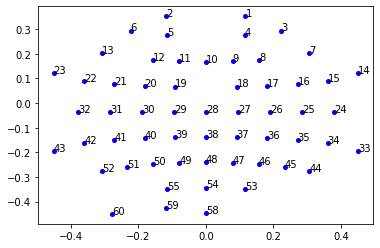

In [108]:
loc_xy = sio.loadmat('../../datasets/EEG/Layout_only_data_chans.mat')['layout'][0,0][0]
ch_nb = sio.loadmat('../../datasets/EEG/Layout_only_data_chans.mat')['layout'][0,0][10]

plt.figure()
for i in range(N):
    plt.plot(loc_xy[i,0], loc_xy[i,1], '.b', ms=8)
    plt.text(loc_xy[i,0], loc_xy[i,1], str(ch_nb[i])[1:-1])

plt.show()

## Exercises

- Apply the metrics to filtered EEG time series.
- Search for statistically significant differences in the metrics between the two conditions.